In [1]:
import random
import math
import time
import json
import os
from numba import jit

import numpy as np
from tqdm import tqdm
from PIL import Image

## read image

In [2]:
img = np.array(Image.open("./lab3_data/mona-lisa-damaged.png"), dtype=np.float32)[:, :, 0]
m, n = img.shape
print(img.shape)
C = np.array([0, 64, 128, 192, 255], dtype=np.float32)

(252, 480)


In [3]:
L = np.zeros((m, n, len(C)), dtype=np.float64)
U = np.zeros((m, n, len(C)), dtype=np.float64)
D = np.zeros((m, n, len(C)), dtype=np.float64)
R = np.zeros((m, n, len(C)), dtype=np.float64)
######
phi = np.zeros((m, n, len(C)))

g = np.zeros((len(C), len(C)), dtype=np.float32)
for i in range(len(C)):
    for j in range(len(C)):
        g[i, j] = -abs(C[i] - C[j])


q = np.zeros((m, n, len(C)), dtype=np.float32)
def call_q(i, j, k):
    if img[i, j] != 0:
        return -abs(img[i, j] - C[k])
    else:
        return 0
for i in range(m):
    for j in range(n):
        for c in range(len(C)):
            q[i, j, c] = call_q(i, j, c)

#####
#####
@jit(nopython=True)
def update_left(i, j, k, direction, phi, C):
    values = np.zeros((len(C),), dtype=np.float32)
    for k_ in range(len(C)):
        values[k_] = direction[i, j-1, k_] + 0.5*q[i, j-1, k_] - phi[i, j-1, k_] + g[k_, k]
    return values.max()

@jit(nopython=True)
def update_upper(i, j, k, direction, phi, C):
    values = np.zeros((len(C),), dtype=np.float32)
    for k_ in range(len(C)):
        values[k_] = direction[i-1, j, k_] + 0.5*q[i-1, j, k_] - phi[i-1, j, k_] + g[k_, k]
    return values.max()

#####
@jit(nopython=True)
def update_right(i, j, k, direction, phi, C):
    values = np.zeros((len(C),), dtype=np.float32)
    for k_ in range(len(C)):
        values[k_] = direction[i, j+1, k_] + 0.5*q[i, j+1, k_] + phi[i, j+1, k_] +g[k_, k]
    return values.max()


@jit(nopython=True)
def update_down(i, j, k, direction, phi, C):
    values = np.zeros((len(C),), dtype=np.float32)
    for k_ in range(len(C)):
        values[k_] = direction[i+1, j, k_] + 0.5*q[i+1, j, k_] + phi[i+1, j, k_] + g[k_, k]
    return values.max()


####
def restore_k(i, j, C):
    values = list()
    for k_ in range(len(C)):
        values.append(L[i, j, k_] + R[i, j, k_] + q[i, j, k_] - phi[i, j, k_])
    return C[values.index(max(values))]

## 10 steps of trw-s

In [4]:
for i in reversed(range(0, m-1)):
    for j in reversed(range(0, n-1)):
        for c in range(len(C)):
            R[i, j, c] = update_right(i, j, c, R, phi, C)
            D[i, j, c] = update_down(i, j, c, D, phi, C)

In [5]:
for iteration in tqdm(range(10)):
    # forward
    for i in range(1, m):
        for j in range(1, n):
            for c in range(len(C)):
                L[i, j, c] = update_left(i, j, c, L, phi, C)
                U[i, j, c] = update_upper(i, j, c, U, phi, C)
                phi[i, j, c] = (L[i, j, c] + U[i, j, c] - R[i, j, c] - D[i, j, c])/2
    # backward
    for i in reversed(range(0, m-1)):
        for j in reversed(range(0, n-1)):
            for c in range(len(C)):
                R[i, j, c] = update_right(i, j, c, R, phi, C)
                D[i, j, c] = update_down(i, j, c, D, phi, C)
                phi[i, j, c] = (L[i, j, c] + U[i, j, c] - R[i, j, c] - D[i, j, c])/2

100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


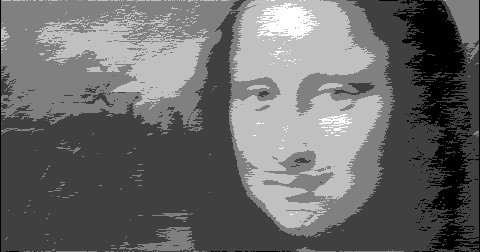

In [6]:
new_img = np.zeros((m, n), dtype=np.uint8)
for i in range(0, m):
    for j in range(1, n-1):
        new_img[i, j] = restore_k(i, j, C)
Image.fromarray(new_img)